In [3]:
import sys

sys.path.append('../')

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [5]:
set_plot_sizes(12, 14, 16)

In [14]:
PATH = '../data/bulldozers'
df_raw = pd.read_feather(f'{PATH}/tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [15]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [27]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [('TRAIN RMS Error', rmse(m.predict(X_train), y_train)), 
           ('VAL RMS Error', rmse(m.predict(X_valid), y_valid)),
           ('R^2 TRAIN', m.score(X_train, y_train)), 
           ('R^2 VAL', m.score(X_valid, y_valid))]
    if hasattr(m, 'oob_score_'): res.append(('OOB SCORE', m.oob_score_))
    for score_type, score in res:
        print(score_type, ' ', score)

In [28]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200


In [29]:
df_raw.shape

(401125, 65)

In [30]:
set_rf_samples(50000)

In [31]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

TRAIN RMS Error   0.20635028140035236
VAL RMS Error   0.2512111259037204
R^2 TRAIN   0.9110092315457571
R^2 VAL   0.8872995334392263
OOB SCORE   0.8938876545076292


In [32]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:, 0]), np.std(preds[:, 0])

CPU times: user 1.55 s, sys: 4.83 ms, total: 1.56 s
Wall time: 1.55 s


(9.28198906567052, 0.3297943730247762)

In [34]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:, 0]), np.std(preds[:, 0])

CPU times: user 65.6 ms, sys: 59 ms, total: 125 ms
Wall time: 528 ms


(9.28198906567052, 0.3297943730247762)

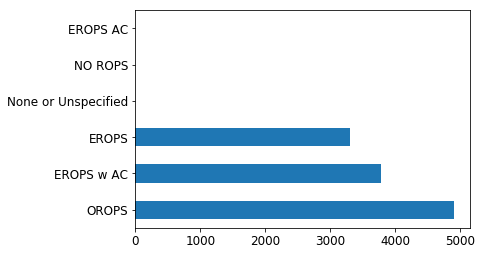

In [35]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh()

In [36]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.835186,0.276838
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.570648,0.264936
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.683281,0.220906


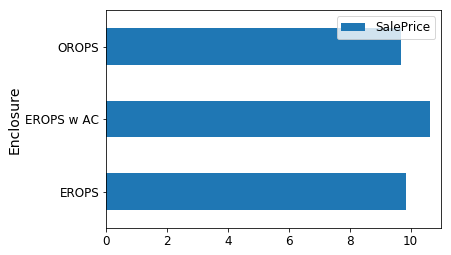

In [37]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0, 11))

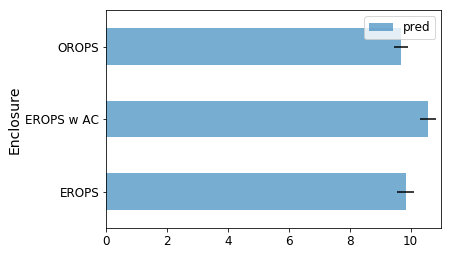

In [38]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0, 11))

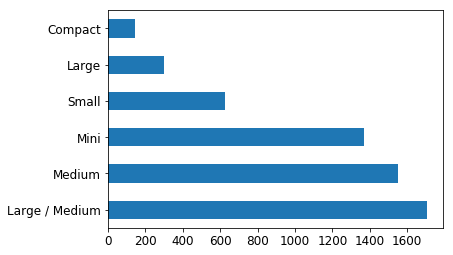

In [40]:
raw_valid.ProductSize.value_counts().plot.barh()

In [43]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby('ProductSize').mean().sort_values('pred_std', ascending=False)
summ

,SalePrice,pred,pred_std
ProductSize,,,
Large,10.470589,10.376888,0.356777
Compact,9.735093,9.853989,0.347687
Small,10.324448,10.321286,0.312936
Large / Medium,10.691871,10.646286,0.290825
Medium,10.681511,10.610656,0.288514
Mini,9.535147,9.558347,0.250201


In [44]:
(summ.pred_std / summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.035284
Large             0.034382
Small             0.030320
Large / Medium    0.027317
Medium            0.027191
Mini              0.026176
dtype: float64

In [45]:
fi = rf_feat_importance(m, df_trn)
fi[:10]

,cols,imp
5,YearMade,0.171029
37,Coupler_System,0.107455
13,ProductSize,0.087000
14,fiProductClassDesc,0.083739
63,saleElapsed,0.049460
10,fiSecondaryDesc,0.049099
2,ModelID,0.048228
38,Grouser_Tracks,0.047513
39,Hydraulics_Flow,0.046501
19,Enclosure,0.038531


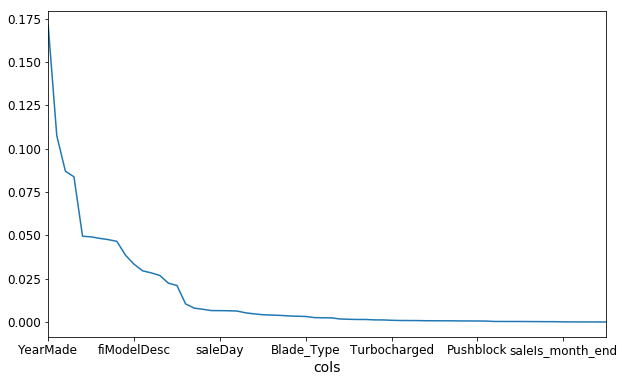

In [49]:
fi.plot('cols', 'imp', figsize=(10, 6), legend=False)

In [51]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh',
                   figsize=(12,7), legend=False)

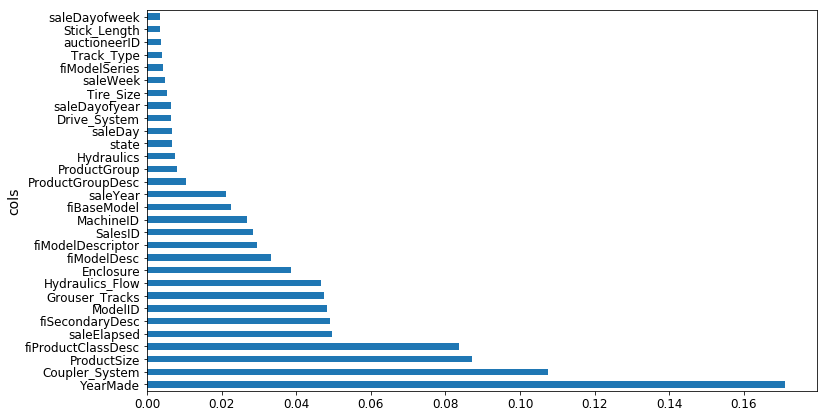

In [52]:
plot_fi(fi[:30])

In [53]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

24

In [54]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [55]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                          max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

TRAIN RMS Error   0.20686316063010804
VAL RMS Error   0.2456784070950091
R^2 TRAIN   0.9105663124765025
R^2 VAL   0.8922091369504397
OOB SCORE   0.894200227662837


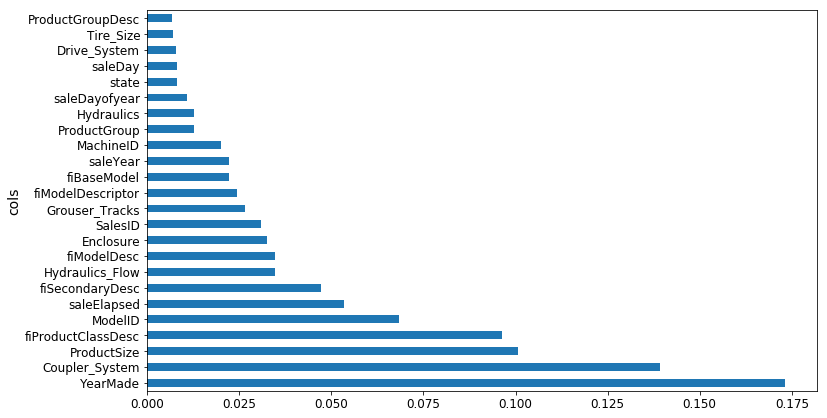

In [56]:
fi= rf_feat_importance(m, df_keep)
plot_fi(fi)

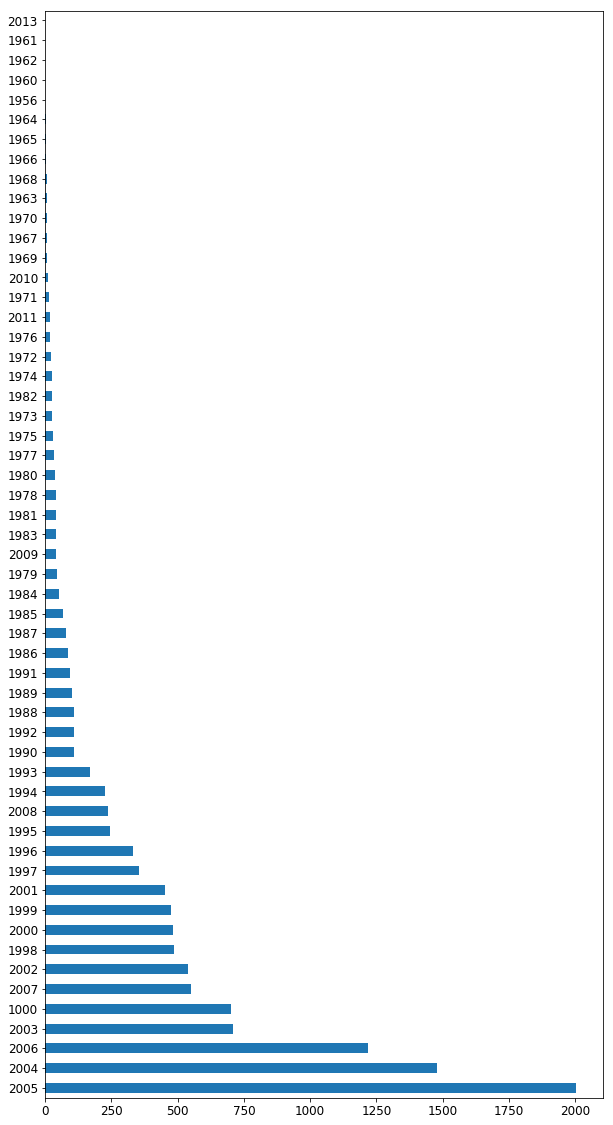

In [58]:
# Check YearMade

x.YearMade.value_counts().plot.barh(figsize=(10,20))

In [62]:
flds = ['YearMade', 'SalePrice', 'pred', 'pred_std']
ym_summ = x[flds].groupby('YearMade', as_index=False).mean().sort_values(
    'pred_std', ascending=False)
ym_summ

,YearMade,SalePrice,pred,pred_std
1,1956,8.987197,9.388850,0.435469
3,1961,9.132379,9.516681,0.406035
0,1000,9.769063,9.668818,0.369753
22,1980,9.949491,9.996295,0.330340
12,1970,9.496778,9.475867,0.328459
18,1976,10.055493,9.988895,0.325578
19,1977,9.876412,9.878730,0.317656
15,1973,9.688554,9.634976,0.315160
20,1978,9.962585,9.970671,0.313664
10,1968,9.573605,9.581807,0.312351


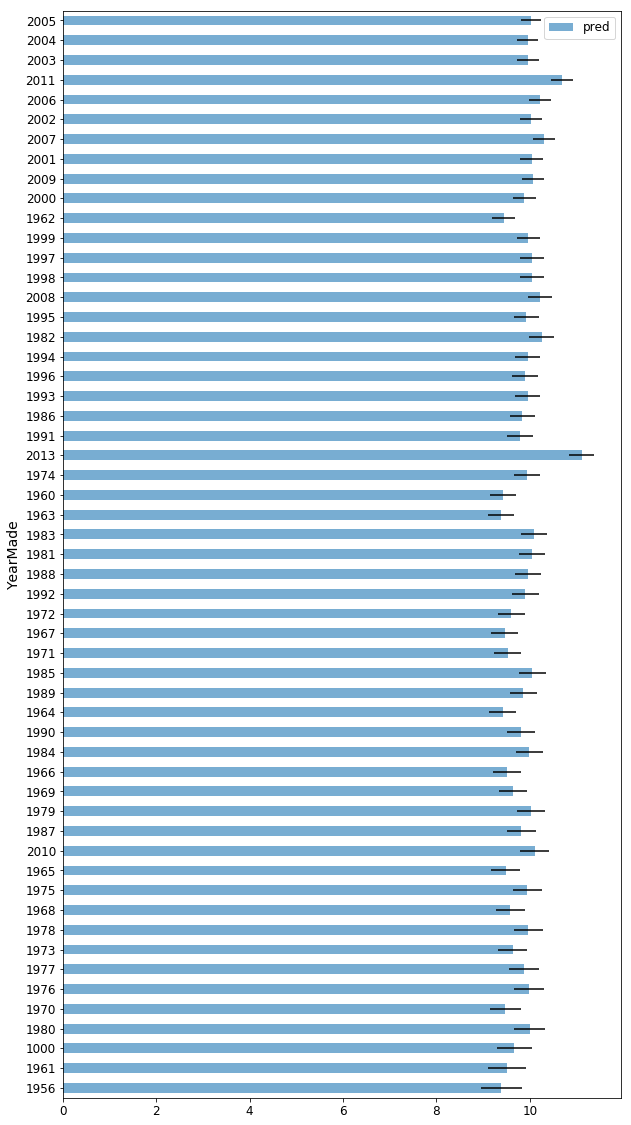

In [65]:
ym_summ.plot('YearMade', 'pred', 'barh', 
             xerr='pred_std', alpha=0.6, figsize=(10,20))

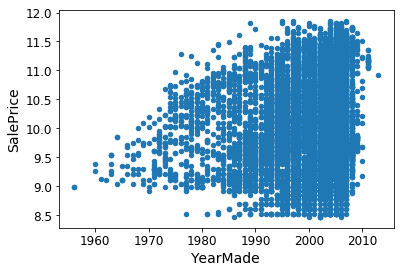

In [69]:
raw_valid[raw_valid['YearMade'] > 1000].plot.scatter('YearMade', 'SalePrice')

In [71]:
raw_valid[raw_valid.YearMade == 1000].shape

(702, 65)

In [73]:
raw_valid.YearMade.dtype

dtype('int64')

In [76]:
raw_train[raw_train.YearMade == 1000].shape

(37483, 65)

In [79]:
clean_df = df_raw[df_raw.YearMade > 1000]
df_trn, y_trn, nas = proc_df(clean_df, 'SalePrice')

n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(clean_df, n_trn)

In [80]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                          max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

TRAIN RMS Error   0.19202105268840614
VAL RMS Error   0.2396784340551913
R^2 TRAIN   0.9221822881709636
R^2 VAL   0.8991034534150817
OOB SCORE   0.9055563416529375


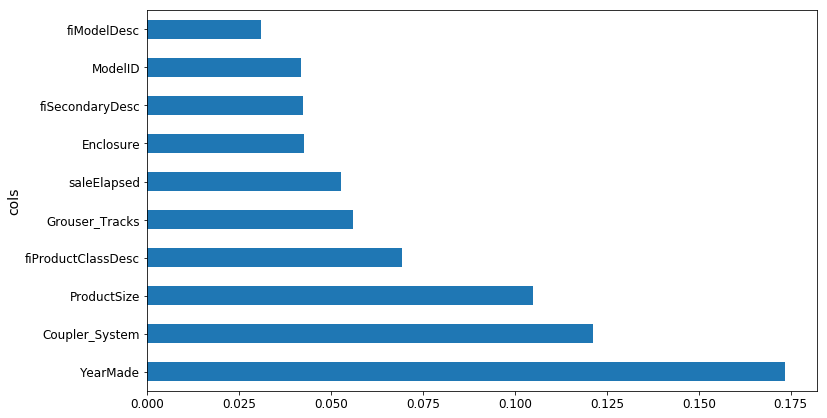

In [83]:
fi = rf_feat_importance(m, df_trn)
plot_fi(fi[:10])

In [91]:
shuffled_Coupler = X_train.copy()

In [92]:
import random
coupler_vals = list(shuffled_Coupler['Coupler_System'])

In [94]:
random.shuffle(coupler_vals)

In [96]:
shuffled_Coupler['Coupler_System'] = coupler_vals

In [97]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                          max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(shuffled_Coupler, y_train)
print_score(m)

TRAIN RMS Error   0.1918470624315639
VAL RMS Error   0.2392597724332927
R^2 TRAIN   0.9223232455232747
R^2 VAL   0.8994556304395258
OOB SCORE   0.905851689771038


In [98]:
shuffled_ProductSize = X_train.copy()
product_size_vals = list(shuffled_ProductSize['ProductSize'])
random.shuffle(product_size_vals)
shuffled_ProductSize['ProductSize'] = product_size_vals

In [99]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                          max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(shuffled_ProductSize, y_train)
print_score(m)

TRAIN RMS Error   0.19902527600860248
VAL RMS Error   0.257786816359399
R^2 TRAIN   0.9164017408400138
R^2 VAL   0.8832814749653971
OOB SCORE   0.8992668091945222


In [104]:
df_keep = df_trn.copy()
del df_keep['Coupler_System']
X_train, X_valid = split_vals(df_keep, n_trn)

In [105]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                          max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

TRAIN RMS Error   0.19177339805990454
VAL RMS Error   0.23853158573305894
R^2 TRAIN   0.9223828858501668
R^2 VAL   0.9000667123358331
OOB SCORE   0.9058984233273382


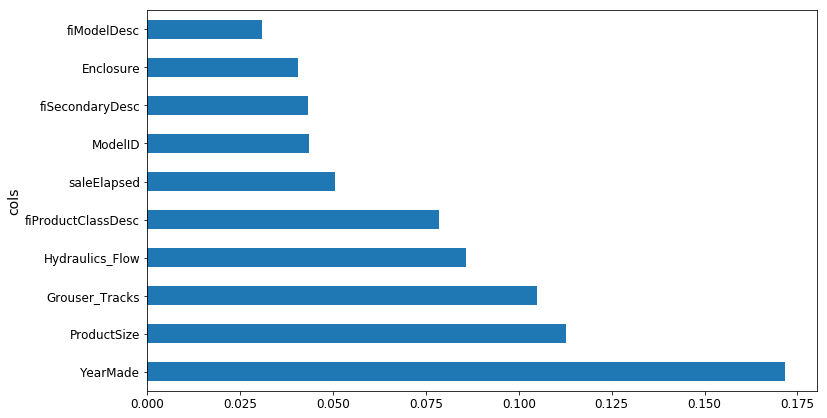

In [106]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi[:10])

In [111]:
from collections import Counter
desc_count = Counter(raw_valid['fiProductClassDesc'])

In [115]:
desc_types = sorted(list(desc_count.keys()))
desc_types

['Backhoe Loader - 0.0 to 14.0 Ft Standard Digging Depth',
 'Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth',
 'Backhoe Loader - 15.0 to 16.0 Ft Standard Digging Depth',
 'Backhoe Loader - 16.0 + Ft Standard Digging Depth',
 'Backhoe Loader - Unidentified',
 'Hydraulic Excavator, Track - 0.0 to 2.0 Metric Tons',
 'Hydraulic Excavator, Track - 11.0 to 12.0 Metric Tons',
 'Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons',
 'Hydraulic Excavator, Track - 14.0 to 16.0 Metric Tons',
 'Hydraulic Excavator, Track - 16.0 to 19.0 Metric Tons',
 'Hydraulic Excavator, Track - 19.0 to 21.0 Metric Tons',
 'Hydraulic Excavator, Track - 2.0 to 3.0 Metric Tons',
 'Hydraulic Excavator, Track - 21.0 to 24.0 Metric Tons',
 'Hydraulic Excavator, Track - 24.0 to 28.0 Metric Tons',
 'Hydraulic Excavator, Track - 28.0 to 33.0 Metric Tons',
 'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
 'Hydraulic Excavator, Track - 33.0 to 40.0 Metric Tons',
 'Hydraulic Excavator, Track - 4.0 to 5.0 M

In [125]:
prefix_to_ordinal = {
    'Backhoe Loader': 0,
    'Hydraulic Excavator': 1,
    'Motorgrader': 2,
    'Skid Steer Loader': 3,
    'Track Type Tractor': 4,
    'Wheel Loader': 5
}

def convert_ord(desc):
    for desc_type in prefix_to_ordinal.keys():
        if str(desc).startswith(desc_type):
            return prefix_to_ordinal[desc_type]


fix_ProductClass = df_raw.copy()
fix_ProductClass['fiProductClassDescSimplified'] = fix_ProductClass['fiProductClassDesc'].apply(convert_ord) 
df_trn, y_trn, nas = proc_df(fix_ProductClass, 'SalePrice')

In [127]:
del df_trn['Coupler_System']
del df_trn['fiProductClassDesc']

In [129]:
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(fix_ProductClass, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                          max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

TRAIN RMS Error   0.20529894189395423
VAL RMS Error   0.2790215392487333
R^2 TRAIN   0.9107700590303927
R^2 VAL   0.856385701343176
OOB SCORE   0.8917300769269014


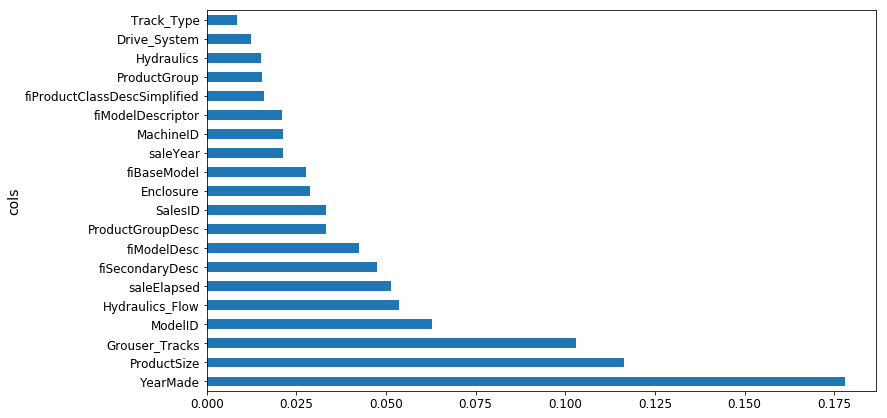

In [132]:
fi = rf_feat_importance(m, df_trn)
plot_fi(fi[:20])